# Vector Space Models of Meaning / Composition Functions

What are we going to learn?

- what is a vector space and how we can build it
- how we can improve word representations in the vector space
- how we can use word-based vector space to represent more complex structures, e.g. phrases
- how we can use vector space for NLP tasks, e.g. phrase semantic similarity task
- why and how we can reduce complexity of the vector space

----

### What is a Vector Space?

*Vector space* allows us to represent meaning of each word with a vector.
A vector is a numeric representation, e.g. `king = [0.5, 0.1, 0.8, -0.3]`. We don't really know what all of the numbers in such vectors mean, but we can try to interpret them.
For example, consider the example below, where each word is represented with a vector consisting of different colour bars.
Every column consists of multiple bars and each column can be thought of as a single, fixed feature.

*Rows x columns is the vector space matrix (often referred to as a word embedding matrix).*

Note that the intensity of the colours also differ, e.g. each bar can reach a max (very red) and a low (very blue) value. We normaly do not know what these values are, they are learned automatically in neural networks. For now, let's imagine that the highest value is +2 and the lowest is -2.

<img src="kingqueen.png" alt="drawing" width="700"/>

We could speculate about differences between vectors to understand them better:

- Note that 'man' and 'boy' are similar with each other in some columns. It is also the case that 'girl' and 'woman' are similar with each other in exactly same columns. At the same time, other words are quite different from either of the four words of interest along those columns. Does it mean we found where the meaning of 'gender' is strongly encoded?
- We can also see that 'boy' and 'girl' are similar in some columns and different from 'man' and 'woman' in the same columns. Does it mean that the idea of 'youth' or 'age' is captured in those parts of the vectors?
- Notice how different the 'water' vector is from all other vectors across some columns. Did those dimensions learn to encode differences between human and non-human objects?
- In some columns, 'king' and 'queen' are very similar to each other and different from other words. Did we learn the concept of 'royalty'?
- There is a red column that crosses all words: what could be captured in this particular bar column?
- Do you notice anything else?

We use vector space to operate with words. We need to create one from the _reference corpus_.

---

### How do we *generally* create a Vector Space?

Vector spaces are created by learning from large corpora, e.g. BNC.
The size of the corpora matters - more examples of word use in different contexts help us to capture more fine-grained meaning with even tiny differences.
Small corpus generally might not work very well because it captures only some meaning of the words.

For example, if in our corpora we have a meaning of a `bank` as a financial institute, we cannot use learned vector space to encode the meaning of a `river bank`, given that this meaning occurs in our task dataset.
Task dataset is the dataset of words that will be encoded within our vector space. Task dataset *might* contain words, which were never present in the vector space, think `money bank` and `river bank`. It is our task to ensure that there is no such discrepancy between the target dataset and the vector space.

A vector space is created by looking at all uses of all words in a big corpus of texts.

We need to construct vector space for our task dataset.
The best solution would be to use the dataset used in [1], which is British National Corpus.  
But for simplicity and purpose of this lecture, we are going to work with Gutenberg project, offered by nltk.

We are going to represent meaning of each word through its context, e.g. word frequency.

In [1]:
import nltk

nltk.download('gutenberg')
corpus = nltk.corpus.gutenberg.fileids()
print(corpus)

['austen-emma.txt', 'austen-persuasion.txt', 'austen-sense.txt', 'bible-kjv.txt', 'blake-poems.txt', 'bryant-stories.txt', 'burgess-busterbrown.txt', 'carroll-alice.txt', 'chesterton-ball.txt', 'chesterton-brown.txt', 'chesterton-thursday.txt', 'edgeworth-parents.txt', 'melville-moby_dick.txt', 'milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/xilini/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [2]:
emma = nltk.corpus.gutenberg.words('austen-emma.txt')
len(emma)

192427

In [3]:
len(corpus)

18

In [4]:
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

def preprocess(s):
    '''
    split text into words, lowercase them, remove punctuation and stopwords,
    we need to keep words which make sense and can be informative for our task
    '''
    return [w.lower().strip(string.punctuation) for w in s if w.lower() not in stopwords.words('english')]

def do_word_count(corpus):
    '''
    let's count all words in our texts,
    we will need this information to ignore the least frequent words,
    why? least frequent words are typically not that informative
    '''
    word_count = nltk.FreqDist()
    for filename in corpus:
        print('reading file', filename)
        fn_text = nltk.corpus.gutenberg.words(filename)
        print(len(fn_text))
        word_count.update(preprocess(fn_text))
    return word_count

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xilini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# testing our function
preprocess(['I am making a very important test.!'])

['i am making a very important test']

In [6]:
dataset = do_word_count(corpus)

reading file austen-emma.txt
192427
reading file austen-persuasion.txt
98171
reading file austen-sense.txt
141576
reading file bible-kjv.txt
1010654
reading file blake-poems.txt
8354
reading file bryant-stories.txt
55563
reading file burgess-busterbrown.txt
18963
reading file carroll-alice.txt
34110
reading file chesterton-ball.txt
96996
reading file chesterton-brown.txt
86063
reading file chesterton-thursday.txt
69213
reading file edgeworth-parents.txt
210663
reading file melville-moby_dick.txt
260819
reading file milton-paradise.txt
96825
reading file shakespeare-caesar.txt
25833
reading file shakespeare-hamlet.txt
37360
reading file shakespeare-macbeth.txt
23140
reading file whitman-leaves.txt
154883


In [7]:
import pickle

pickle.dump(dataset, open('./reference_corpus.txt', 'wb'))

In [8]:
import pickle

reference_corpus = pickle.load(open('./reference_corpus.txt', 'rb'))

In [9]:
reference_corpus

FreqDist({'': 422409, 'shall': 11684, 'said': 9429, 'unto': 9010, 'lord': 8590, 'thou': 6759, 'one': 6224, 'man': 5616, 'thy': 5609, 'god': 5287, ...})

----

### The Task Dataset: Phrase Similarity

Our task is phrase similarity task proposed in [1]. We are going to use the dataset that the authors provided.

The main idea is to build a model that can automatically capture differences in meanings between _phrases_.
Phrases consist of nouns and verbs.

There are always two ground-truth **reference phrases** for a single reference verb:

`the fire glowed` and `the face glowed`

Each reference phrase has two variations, which introduce either a **high** or **low similarity** with the original phrase:

`the fire glowed` VS `the fire burned` (high) and `the fire beamed` (low)

These verbs are mapped differently for the second reference phrase:

`the face glowed` VS `the face beamed` (high) and `the face burned` (low)

For each combination of a reference phrase and high/low similarity phrase, we have a human rating. This rating is the numeric ground-truth that will be compared against model's predictions of similarity.

The **main task for the model** is to (i) encode reference phrase, (ii) encode either a high or low similarity phrase, (iii) predict the similarity score between the reference phrase and both high/low similarity phrases. The former should have a higher similarity score and the latter should be very low. We evaluate by comparing against human ratings.

We need the ground-truth phrases and variations with different similarities to capture:
1. semantics of combinations of intransitive verbs and **different** nouns
2. differences in nouns allow us to learn about properties of specific objects as reflected in text: both face and fire can glow, but only fire burns, while only face beams.

More data examples (from the paper) are below:

<img src="lapataexample.png" alt="drawing" width="700"/>

**Question**: do we capture any metaphoric meaning with these constructions?

We will adopt the following terminology:

**Reference phrase** is `the fire glowed` (noun + reference intransitive verb)

**Landmark phrases** are two types of phrases:

High similarity landmark: `the fire burned` (noun + verb from high) (this phrase is HIGHLY similar to the reference phrase)
Low similarity landmark: `the fire beamed` (noun + verb from low) (this phrase is NOT REALLY similar to the reference phrase)

---

### Pre-processing Task Dataset

Since our task dataset is different from reference corpus, we need to make sure that all words from the task dataset can be found in our reference corpus.  
Otherwise, we will not be able to build vectors based on co-occurrences simply because our words of interest have never appeared in the reference texts and our model simply does not about some of the words from the target dataset.

In [10]:
# load the task dataset
with open('./mitchell_lapata_acl08.txt', 'r') as f:
    phrase_dataset = f.read().splitlines()

for line in phrase_dataset[:10]:
    print(line)
    
# get all unique words
words = []
for line in phrase_dataset[1:]:
    _, verb, noun, landmark, _, _ = line.split()
    if verb not in words:
        words.append(verb)
    if noun not in words:
        words.append(noun)
    if landmark not in words:
        words.append(landmark)

participant verb noun landmark input hilo
participant20 stray thought roam 7 low
participant20 stray discussion digress 6 high
participant20 stray eye roam 7 high
participant20 stray child digress 1 low
participant20 throb body pulse 5 high
participant20 throb head shudder 2 low
participant20 throb voice shudder 3 low
participant20 throb vein pulse 6 high
participant20 chatter machine click 4 high


The task for the human: rate reference and landmark in terms of semantic similarity on the scale from 1 to 7, how similar they are? 1 is not similar, 7 is very similar

Example item from the data:

`participant20 stray discussion digress 6 high`

1. participant: `participant20`, e.g. same participant has been shown multiple pairs of reference and landmark (either high or low) phrases
2. reference phrase: combination of noun and verb columns, e.g. `discussion stray`
3. landmark phrase: combination of noun and landmark columns, e.g. `discussion digress`
4. input: human rating, e.g. `7`
5. hilo: high/low, type of the landmark, e.g. `high` (for each reference phrase, the dataset should have both low and high similarity landmarks

In [11]:
# are there any words in the task dataset which do not appear in the reference corpus?
to_remove = []
for w in words:
    if w not in reference_corpus:
        print(w)
        to_remove.append(w)
# if some words are not found in the reference corpus, makes sense to ignore whole phrases with such words

ricochet
flick
slump
erupt
export
fluctuate


In [12]:
# how many words does our task dataset has in general?
print(len(words))

95


#### Why ensuring that there are no missing words is important?

We typically do not have resources to pre-train word embeddings on the task dataset.
We normally use existing pre-trained embeddings, because they encode large vector space with words in different contexts, e.g. `GoogleNews-vectors-negative300.bin`. These embeddings were created with the goal in mind of capturing wider meaning of words, so we should benefit from them. Note that the domains of your reference corpus and task dataset matter as well - to avoid discrepancies in vector spaces we want both corpora to be approximately in the same domain or cover most of the Web (more popular approach these days).

If some words from your task dataset are not in the reference corpus (that is, they are also not in your vector space), you typically would look for a better, larger vector space or train your own space. In our case, we exclude non-present words, but this problem should not occur later when we work with word embeddings, because they are either trained on the task dataset or they are taken from an extremely large corpus which is less likely to not contain even a single word from a language.

In [13]:
# pre-processing the task dataset
# we are removing all phrases which contain words, which are not in the reference corpus

processed_phrase_dataset = []
for line in phrase_dataset:
    _, verb, noun, landmark, _, _ = line.split()
    if verb in to_remove or noun in to_remove or landmark in to_remove:
        continue
    processed_phrase_dataset.append(line)

target_words = []
for line in processed_phrase_dataset[1:]:
    _, verb, noun, landmark, _, _ = line.split()
    if verb not in target_words:
        target_words.append(verb)
    if noun not in target_words:
        target_words.append(noun)
    if landmark not in target_words:
        target_words.append(landmark)

In [14]:
# how many words do we have after pre-processing
len(target_words)

80

Now our task dataset (phrase similarity dataset) matches our vector space: all words in the task dataset occur in the vector space

### Computing Vector Space for the Target Dataset

We are going to take every target word and compute their embeddings based on frequency of the neighbouring words as defined by the context window.

Often one would use the task dataset itself to compute such embeddings, but our phrases are in isolation, so, once again, that is the reason why we need reference corpus, where phrases are contextualised, e.g. exist in some context of use.

In [15]:
# transforming words in all texts into a single string, e.g. we want to later extract context of target words from this string

texts_as_words = []
for filename in corpus:
    fn_text = nltk.corpus.gutenberg.words(filename)
    print(filename)
    fn_text = [w.lower().strip(string.punctuation) for w in fn_text] #if w.lower() not in stopwords.words('english')]
    fn_text = [w for w in fn_text if w != '']
    texts_as_words.append(fn_text)

austen-emma.txt
austen-persuasion.txt
austen-sense.txt
bible-kjv.txt
blake-poems.txt
bryant-stories.txt
burgess-busterbrown.txt
carroll-alice.txt
chesterton-ball.txt
chesterton-brown.txt
chesterton-thursday.txt
edgeworth-parents.txt
melville-moby_dick.txt
milton-paradise.txt
shakespeare-caesar.txt
shakespeare-hamlet.txt
shakespeare-macbeth.txt
whitman-leaves.txt


In [16]:
import json
import itertools

texts_as_words = list(itertools.chain.from_iterable(texts_as_words))

with open('./texts-as-words.json', 'w') as f:
    json.dump(texts_as_words, f)

In [17]:
with open('./texts-as-words.json', 'r') as f1:
    texts_as_words = json.load(f1)

In [20]:
import tqdm

def compute_space(window_size, corpus):
    '''
    this function builds vector space for each word in the task dataset
    the space is limited by the window_size : how many words on both sides of the target word we should use to encode it?
    the space is counting frequency of context words, e.g. the idea of co-occurence
    '''
    
    space = nltk.ConditionalFreqDist()

    for index in tqdm.tqdm(range(len(corpus))):
        # current word
        current = corpus[index]

        if current in target_words:
                                    
            # get future context for the first word only
            # because there is no past context for the first word
            if index == 0:
                for cxword_index_after in range(window_size):
                    cxword_after = corpus[cxword_index_after + 1]
                    space[current].update([cxword_after])      
                    
            # context before and after the current word: specified by context size
            if index > 0:
                
                # extract words within the context window for the current word that occur BEFORE
                for cxword_index_before in range(max(index - window_size, 0), index):
                    # range is inclsuive the first value but exclusive the second
                    cxword_before = corpus[cxword_index_before]
                    # In a ConditionalFreqDist, if 'current' is not a condition yet,
                    # then accessing it creates a new empty FreqDist for 'current'
                    # The FreqDist method inc() increments the count for the given item by one.
                    space[current].update([cxword_before])

                # extract words within the context window for the current word that occur AFTER
                if index + window_size < len(corpus):
                    for cxword_index_after in range(index, max(index + window_size, 0)):
                        cxword_after = corpus[cxword_index_after + 1]
                        space[current].update([cxword_after])

                # if window_size AFTER exceeds the length of the corpus (needed for the words in the end)
                else:
                    for cxword_index_after in range(index + 1, len(corpus)):
                        cxword_after = corpus[cxword_index_after]
                        space[current].update([cxword_after])

    return space

In [21]:
sp = compute_space(5, texts_as_words)
pickle.dump(sp, open('./vector-space-freq.p', 'wb'))

100%|████████████████████████████| 2199204/2199204 [00:01<00:00, 1107315.55it/s]


In [22]:
sp

<ConditionalFreqDist with 80 conditions>

In [23]:
target_words[:10]

['stray',
 'thought',
 'roam',
 'discussion',
 'digress',
 'eye',
 'child',
 'throb',
 'body',
 'pulse']

In [24]:
print('stray:\n', sp['stray'].most_common(10), '\n')
print('thought:\n', sp['thought'].most_common(10), '\n')
print('discussion:\n', sp['discussion'].most_common(10), '\n')

stray:
 [('the', 11), ('to', 6), ('from', 5), ('a', 4), ('of', 4), ('and', 4), ('or', 3), ('near', 3), ('me', 3), ('letter', 2)] 

thought:
 [('i', 543), ('the', 506), ('of', 444), ('and', 365), ('he', 342), ('to', 326), ('it', 302), ('a', 261), ('that', 245), ('she', 215)] 

discussion:
 [('of', 14), ('the', 12), ('and', 10), ('a', 6), ('in', 6), ('to', 5), ('one', 4), ('their', 4), ('an', 3), ('s', 3)] 



**The problem**: the size of the vectors might impact our representations. What happens if we take bigger sizes for our word vectors?

In [25]:
print('stray:\n', sp['stray'].most_common(100), '\n')
print('thought:\n', sp['thought'].most_common(100), '\n')
print('discussion:\n', sp['discussion'].most_common(100), '\n')

stray:
 [('the', 11), ('to', 6), ('from', 5), ('a', 4), ('of', 4), ('and', 4), ('or', 3), ('near', 3), ('me', 3), ('letter', 2), ('as', 2), ('up', 2), ('him', 2), ('might', 2), ('s', 2), ('into', 2), ('you', 2), ('out', 2), ('side', 2), ('with', 2), ('returning', 1), ('exercise', 1), ('boy', 1), ('on', 1), ('an', 1), ('obstinate', 1), ('he', 1), ('took', 1), ('any', 1), ('how', 1), ('beautifully', 1), ('wish', 1), ('church', 1), ('then', 1), ('parson', 1), ('preach', 1), ('car', 1), ('like', 1), ('cat', 1), ('left', 1), ('swaying', 1), ('at', 1), ('front', 1), ('door', 1), ('revellers', 1), ('if', 1), ('there', 1), ('half', 1), ('almost', 1), ('complete', 1), ('solitude', 1), ('they', 1), ('could', 1), ('so', 1), ('only', 1), ('four', 1), ('finally', 1), ('last', 1), ('merry', 1), ('maker', 1), ('ran', 1), ('not', 1), ('understand', 1), ('let', 1), ('little', 1), ('too', 1), ('lest', 1), ('guinea', 1), ('hen', 1), ('fall', 1), ('again', 1), ('purpose', 1), ('popping', 1), ('off', 1), (

We can remove stop words since they are not adding anything useful to our representations.

In [26]:
filtered_words = [word for word in texts_as_words if word.lower() not in stopwords.words('english')]

print('excluding stopwords from the semantic space...')

sp2 = compute_space(5, filtered_words)

excluding stopwords from the semantic space...


100%|█████████████████████████████| 1088907/1088907 [00:01<00:00, 943892.89it/s]


In [28]:
pickle.dump(sp2, open('./vector-space-freq-2.p', 'wb'))

In [29]:
sp2 = pickle.load(open('./vector-space-freq-2.p', 'rb'))

In [30]:
print('stray:\n', sp2['stray'].most_common(10), '\n')
print('thought:\n', sp2['thought'].most_common(10), '\n')
print('discussion:\n', sp2['discussion'].most_common(10), '\n')

stray:
 [('near', 3), ('side', 3), ('letter', 2), ('little', 2), ('day', 2), ('might', 2), ('back', 2), ('let', 2), ('hour', 2), ('garden', 2)] 

thought:
 [('would', 188), ('said', 124), ('could', 123), ('one', 106), ('never', 99), ('little', 80), ('man', 67), ('good', 66), ('thought', 66), ('must', 65)] 

discussion:
 [('one', 4), ('every', 2), ('must', 2), ('least', 2), ('given', 2), ('could', 2), ('would', 2), ('book', 2), ('smith', 1), ('intimacy', 1)] 



What about punctuation? We can also remove punctuation from our corpus.

In [31]:
real_words = [w for w in filtered_words if w not in string.punctuation]
print('excluding punctuation from the semantic space...')

sp3 = compute_space(5, real_words)

excluding punctuation from the semantic space...


100%|█████████████████████████████| 1088907/1088907 [00:01<00:00, 944789.71it/s]


In [32]:
pickle.dump(sp3, open('./vector-space-freq-3.p', 'wb'))

In [33]:
sp3 = pickle.load(open('./vector-space-freq-3.p', 'rb'))

In [34]:
print('stray:\n', sp3['stray'].most_common(100), '\n')
print('thought:\n', sp3['thought'].most_common(100), '\n')
print('discussion:\n', sp3['discussion'].most_common(100), '\n')

stray:
 [('near', 3), ('side', 3), ('letter', 2), ('little', 2), ('day', 2), ('might', 2), ('back', 2), ('let', 2), ('hour', 2), ('garden', 2), ('hands', 2), ('sea', 2), ('sun', 2), ('cole', 1), ('carriage', 1), ('horses', 1), ('returning', 1), ('exercise', 1), ('boy', 1), ('obstinate', 1), ('mule', 1), ('liveliest', 1), ('boys', 1), ('fondly', 1), ('pointing', 1), ('took', 1), ('beautifully', 1), ('emma', 1), ('written', 1), ('livelong', 1), ('ever', 1), ('wish', 1), ('church', 1), ('parson', 1), ('preach', 1), ('drink', 1), ('sing', 1), ('aspiring', 1), ('idiot', 1), ('car', 1), ('like', 1), ('cat', 1), ('left', 1), ('swaying', 1), ('unsteadily', 1), ('moon', 1), ('merely', 1), ('us', 1), ('front', 1), ('door', 1), ('revellers', 1), ('half', 1), ('inquiry', 1), ('cooked', 1), ('sense', 1), ('almost', 1), ('complete', 1), ('solitude', 1), ('could', 1), ('wall', 1), ('apparently', 1), ('unwatched', 1), ('soon', 1), ('four', 1), ('finally', 1), ('last', 1), ('merry', 1), ('maker', 1), (

**What did we achieve?**

We have represented each word in our task dataset by the context that it keeps in our reference corpus.
The context differs from word to word and columns (words) do not necessarily overlap.
We also keep frequency of words to represent it as a numeric vector later.

---

### Final processing touches

Lastly, we need to have a single context for all words.
We are going to iterate through our target words and take words from every context and blend them into a single one.

In [35]:
vector_space_task_dataset = pickle.load(open('./vector-space-freq-3.p', 'rb'))

In [36]:
columns = {}
for item in target_words:
    # similar to [1],
    # we identify the most frequent co-occurring words for all target words
    # we need to take those, which seem to be appearing very often in different words' context
    fixed_sem_space = dict(vector_space_task_dataset[item])#.most_common(2000))
    
    for word, freq in fixed_sem_space.items():
        if word not in columns:
            columns[word] = freq
        else:
            if columns[word] < freq:
                columns[word] = freq

In [37]:
sorted_columns = sorted(columns.items(), key=lambda item: item[1], reverse=True)

In [38]:
sorted_columns[:5]

[('man', 814), ('shall', 776), ('said', 613), ('unto', 582), ('every', 498)]

In [39]:
len(sorted_columns)

19646

Next, we will decide on the size of our vectors.
We are going to take the words from the top of the sorted list, because they are the most frequent ones and they are likely to appear in different contexts.

In [40]:
# every target word will be represented through these dimensions (most frequent and sensible words)
dims = dict(sorted_columns[:2000])

Let's build our final vector space!

In [41]:
# building our final vector space for our target words
target_semantic_space = {}
for item in tqdm.tqdm(target_words):
    target_semantic_space[item] = {}
    this_sem_space = dict(vector_space_task_dataset[item])
    # we are going to use context words ONLY, and then take frequency from our vector space
    for other_w in dims.keys():
        if other_w not in this_sem_space.keys():
            target_semantic_space[item][other_w] = [0]
        else:
            target_semantic_space[item][other_w] = [this_sem_space[other_w]]

100%|██████████████████████████████████████████| 80/80 [00:00<00:00, 460.31it/s]


In [42]:
import pandas as pd
df = pd.DataFrame.from_dict(target_semantic_space['face'])
m2 = (df != 0).all()
print(df.loc[:, m2])

   man  shall  said  unto  every  god  hand  lord  one  thou  ...  ivory  \
0  111    114   122    71     30   60    33    88   69    76  ...      1   

   jonathan  furnace  mock  anarchist  incline  cannon  froward  noah  cherub  
0         1        1     1          1        1       1        1     1       6  

[1 rows x 1455 columns]


In [43]:
import pandas as pd
df = pd.DataFrame.from_dict(target_semantic_space['skin'])
m2 = (df != 0).all()
print(df.loc[:, m2])

   man  shall  said  unto  every  hand  lord  one  thou  old  ...  parchment  \
0    7     37     8     1      2     3     2    3     6    4  ...          1   

   complexion  serpent  peculiar  blubber  bone  whereof  hoisted  beating  \
0           3        1         1        6     2        1        1        1   

   shaven  
0       1  

[1 rows x 384 columns]


In [44]:
with open('./target_semantic_space.json', 'w') as f2:
    json.dump(target_semantic_space, f2)

In [45]:
with open('./target_semantic_space.json', 'r') as f3:
    our_space = json.load(f3)

---

### Phrase Similarity Task

We want to make a model that is able to see the differences between phrases / sentences, not solely individual words.  
Then, we will need to test this model and check whether its performance correlates with human judgements.

**Important:**

We need to decide how we are going to combine representations from words into phrase representations.
Since we have every word represented through counts of words from its context, we can do some operations as exemplified below (from [1]):

Let's say we have two vectors: one is for a noun, another one is for a verb.

u = `[15, 16, 5, 6]` (stands for _house_, vector size / number of dimensions = 4)

v = `[4, 5, 3, 4]` (stands for _burn_)

What are the composition functions we can use?

Example 1: `house + burn = house burn`

![title](simple_additive.png)

Example 2: `house * burn = house burn`

![title](simple_multiplicative.png)

Example 3: multiplication and addition combined

![title](combined.png)

Alpha, beta, gamma: three variables, which control how much each constituent contributes to the result

If alpha is `0.0`, it means that no contribution will be given by `u`.

We will set `alpha` = 0, `beta` = 0.95, `gamma` = 0.05 (based on [1]).
It means that for the phrase `house burn`, if we go with the last method we are saying that meaning of `house` is not needed, while it is the meaning of the verb that will contribute the most. The meaning of multiplication of noun and verb is also needed to some extent.



Let's test these representations and see how different they are!

In [46]:
processed_phrase_dataset[-10:]

['participant50 chatter child gabble 6 high',
 'participant50 chatter tooth click 2 high',
 'participant50 reel head whirl 5 high',
 'participant50 reel mind stagger 4 low',
 'participant50 reel industry stagger 5 high',
 'participant50 reel man whirl 3 low',
 'participant50 glow fire beam 7 low',
 'participant50 glow face burn 3 low',
 'participant50 glow cigar burn 5 high',
 'participant50 glow skin beam 7 high']

In [47]:
len(target_words)

80

In [48]:
# the first line is the column name line, we ignore it
column_names = phrase_dataset[0].split()
print(column_names)

dataset = {}

for line in phrase_dataset[1:]:
    participant_id, reference, noun, landmark, rating, hilo = line.split()
    reference_phrase = [noun, reference]
    landmark_phrase = [noun, landmark]

    if participant_id not in dataset:
        dataset[participant_id] = []
    else:
        dataset[participant_id].append((reference_phrase, landmark_phrase, rating, hilo))

['participant', 'verb', 'noun', 'landmark', 'input', 'hilo']


In [49]:
dataset['participant1'][:10]

[(['discussion', 'stray'], ['discussion', 'digress'], '6', 'high'),
 (['eye', 'stray'], ['eye', 'roam'], '1', 'high'),
 (['child', 'stray'], ['child', 'digress'], '1', 'low'),
 (['head', 'reel'], ['head', 'stagger'], '4', 'low'),
 (['mind', 'reel'], ['mind', 'whirl'], '5', 'high'),
 (['industry', 'reel'], ['industry', 'whirl'], '2', 'low'),
 (['man', 'reel'], ['man', 'stagger'], '5', 'high'),
 (['cigarette', 'flare'], ['cigarette', 'erupt'], '1', 'low'),
 (['eye', 'flare'], ['eye', 'flame'], '2', 'high'),
 (['argument', 'flare'], ['argument', 'erupt'], '6', 'high')]

---

### Computing Phrase Similarity

One of the primary methods in which distributional vectors are used is to estimate similarity between words.

The central idea is that words that appear in similar contexts tend to be similar in meaning.
So what we need to do to estimate word similarity from distributional vectors is to compute a similarity measure that determines how similar the vectors of two words are.

There are many similarity measures, but the one that is used the most is **cosine similarity**.
If we consider the vector of a word as an arrow from the origin, then two words should be similar if their vectors go in roughly the same direction.
Cosine similarity measures this as the cosine of the angle between the two vectors. 

$$cosine(u, v) = \frac{\sum_i {u_i v_i}}{|u| |v|}$$

$$|v| = \sqrt{\sum_i v_i^2}$$


#### Why cosine?

The similarity metric between vectors is typically based on the dot product:

<img src="dotproduct.png" alt="drawing" width="700"/>

However, dot products get bigger if the vectors are longer; the vectors are longer if they have higher values in each dimension.
That is, more frequent words will have higher dot products; we do not want a similarity metric that is sensitic to word frequency.

Solution: divide the dot product by the length of the two vectors, which also appears to be a cosine formula for the angle between both vectors.

In [50]:
##
# similarity measure: cosine
#                           sum_i vec1_i * vec2_i
# cosine(vec1, vec2) = ------------------------------
#                        veclen(vec1) * veclen(vec2)
# where
#
# veclen(vec) = squareroot( sum_i vec_i*vec_i )
#

def veclen(vector):
    return math.sqrt(np.sum(np.square(vector)))

def cosine(vector1, vector2):
    veclen1 = veclen(vector1)
    veclen2 = veclen(vector2)
    if veclen1 == 0.0 or veclen2 == 0.0:
        # one of the vectors is empty, the cosine is 0
        return 0.0
    else:
        # we could also simply do:
        dotproduct = np.dot(vector1, vector2)
        #print(vector1, vector2)
        return dotproduct / (veclen1 * veclen2)

In [51]:
def build_phrase_space(phrase, x_names):

    # first we get representations for verb and noun
    subject_space = target_semantic_space[phrase[0]]
    verb_space = target_semantic_space[phrase[1]]
    # representation for house and burn
    
    representation = np.zeros(len(x_names))

    for n, word in enumerate(x_names.keys()):

        # I get v^Ith element from each of the vectors
        subject_value = subject_space[word][0]
        verb_value = verb_space[word][0]

        #out = subject_value + verb_value
        out = subject_value * verb_value
        
        # 6 and 0, if we do summation, we are getting 6
        # if we do mulitplication, we are getting 0
        
        #out = subject_value * 0.2 + verb_value * 0.8
        #out = subject_value * 0.0 + verb_value * 0.95 + (0.05 * subject_value * verb_value)

        representation[n] = out

    return representation

In [52]:
import numpy as np
import math

reference = ['face', 'glow']
landmark_high = ['face', 'beam']
landmark_low = ['face', 'burn']

ref = build_phrase_space(reference, dims)

lhigh = build_phrase_space(landmark_high, dims)

llow = build_phrase_space(landmark_low, dims)

print(ref, ref.shape)
print(lhigh)
print(llow)

[111. 114. 610. ...   0.   0.   0.] (2000,)
[222. 342. 244. ...   0.   0.   0.]
[  444. 10602.   610. ...     0.     0.     0.]


In [53]:
cosine(ref, lhigh)

0.4153545549382808

In [54]:
cosine(ref, llow)

0.19922629518346402

---

### Transforming counts to association weights

So far we have been representing words through vectors that include frequency of context / neighbouring words.
However, one problem is that all words will have high co-occurrence counts with the most frequent context items.
These words become less informative for the model to learn from, because they appear so frequently across the contexts.
Some examples of such words are as follows: i, a, on, with, the, man, could, etc.

Keeping these words and their frequencies will falsely inflate all our similarity estimates.
What we want to know instead is how strongly a target word is associated with a context item: does it appear with the context item more often than we could expect at random? Less often? About as often as we would expect?



There are multiple options for computing degree of association:

- tf-idf (term frequency / inverse document frequency)
- pointwise mutual information (PMI)
- positive mutual information (PPMI): just change negative PMI values to zero
- local mutual information (LMI)

We do PMI here.
The PMI of a target word t and context item c is defined as:
 
$$PMI(t, c) = log \frac{P(t, c)}{P(t) P(c)}$$

All the probabilities are computed from the table of counts. We need:

- $\#(t, c)$: the co-occurrence count of t with c
- $\#(\_, \_)$: the sum of counts in the whole table, across all targets
- $\#(t, \_)$: the sum of counts in the row of target t
- $\#(\_, c)$: the sum of counts in the column of context item c

Then we have: 

- $P(t, c) = \frac{\#(t, c)}{\#(\_,\_)}$
- $P(t) = \frac{\#(t,\_)}{\#(\_,\_)}$
- $P(c) = \frac{\#(\_,c)}{\#(\_,\_)}$

Here is how we compute PPMI from counts:

<img src="ppmi.png" alt="drawing" width="700"/>

In [55]:
#########
# transform the space using positive pointwise mutual information

# target t, dimension value c, then
# PMI(t, c) = log ( P(t, c) / (P(t) P(c)) )
# where
# P(t, c) = #(t, c) / #(_, _)
# P(t) = #(t, _) / #(_, _)
# P(c) = #(_, c) / #(_, _)
#
# PPMI(t, c) =   PMI(t, c) if PMI(t, c) > 0
#                0 else

def ppmi_transform(space, word):
    
    row_sums = {}
    col_sums = {}
    context_word = {}
    
    pmi_return = {}
    
    #(_, _): overall count of occurrences
    overall = 0
    for _, vectors in space.items():
        for _, f in vectors.items():
            overall += f[0]    
    
    for t, vectors in space.items():
        
        if t == word:
            # #(t, _): for each target word, sum up all its counts.
            # row_sums is a dictionary mapping from target words to row sums
            # how many time t appears in the context
            t_sum = 0
            for _, f in vectors.items():
                t_sum += f[0]
            row_sums[t] = t_sum
            
        # #(_, c): for each context word, sum up all its counts
        # col_sums is a dictionary mapping from context word indices to column sums
        #col_sums = {}
        #for c, f in vectors.items():
        #    col_sums[c] = sum([elem[0] for elem in f])
        #print(col_sums)
        
        # #(_, c): for each context word, sum up all its counts
        # col_sums is a dictionary mapping from context word indices to column sums
        for c, f in vectors.items():
            if c not in col_sums:
                col_sums[c] = f[0]
            else:
                col_sums[c] += f[0]

    #print(col_sums)
    #print(row_sums)
    #print(context_word)
    pmi_return[word] = {}
    
    for context_word, context_sums in col_sums.items():
        target_pmi = np.log2((context_sums / overall) / (row_sums[word] / overall) * (col_sums[context_word] / overall))

        pmi_return[word][context_word] = target_pmi
        
    return pmi_return



In [56]:
#target_semantic_space['stray']

In [57]:
for w in target_words:
    
    ppmispace = ppmi_transform(target_semantic_space, w)
    
    for k, v in ppmispace.items():
        print(k)
        for c in list(v)[:5]:
            print(v[c], c)
    break

stray
-2.361634103986254 man
-1.0860896287313941 shall
-1.6253318806902384 said
-2.7841378314487493 unto
-3.6117477379455405 every


---

### Dimensionality reduction

Dimensionality reduction is a method that takes a space where each word has a vector of, say, 10,000 dimensions and reduces it to a space where each word has a vector of something like 300 or 500 dimensions, making the space more manageable.

The new dimensions can be seen as groupings (soft clusterings) of the old dimensions, or as latent semantic classes underlying the old dimensions. A popular choice of dimensionality reduction method is _singular value decomposition (SVD)_. SVD involves representing a set of points in a different space (that is, through a new set of dimensions) in such a way that it brings out the underlying structure of the data.

Here is how we can do this in Python.

In [58]:
#target_semantic_space['man']

In [59]:
# we are going to make a copy of our original vector space with frequencies, which will be later pruned
space_to_reduce = {}
for w in target_words:
    
    space_to_reduce[w] = np.zeros(2000)
    this_sem_space = dict(target_semantic_space[w])
    
    for n, other_w in enumerate(dims.keys()):
        if other_w not in this_sem_space.keys():
            space_to_reduce[w][n] = 0
        else:
            space_to_reduce[w][n] = dims[other_w]

In [ ]:
#space_to_reduce

In [60]:
def svd_transform(space, original_dim, dim_to_keep):
    
    # space is a dictionary mapping words to vectors
    # combine those into a big matrix
    spacematrix = np.empty((len(space.keys()), original_dim))
    rowlabels = sorted(space.keys())

    for index, word in enumerate(rowlabels):
        spacematrix[index] = space[word]

    # start SVD
    umatrix, sigmavector, vmatrix = np.linalg.svd(spacematrix)

    
    # remove the last few dimensions of u and sigma
    utrunc = umatrix[:, :dim_to_keep]
    sigmatrunc = sigmavector[ :dim_to_keep]

    # new space: U %matrixproduct% Sigma_as_diagonal_matrix   
    newspacematrix = np.dot(utrunc, np.diag(sigmatrunc))

    # transform back to a dictionary mapping words to vectors
    newspace = {}
    for index, word in enumerate(rowlabels):
        newspace[word] = newspacematrix[index]
        
    return newspace



In [61]:
new_space = svd_transform(space_to_reduce, 2000, 50)

In [63]:
len(space)

80

In [62]:
# Now, let us inspect the space a bit more

space = space_to_reduce
original_dim = 2000
dim_to_keep = 50

spacematrix = np.empty((len(space.keys()), original_dim))
print(spacematrix.shape)
rowlabels = sorted(space.keys())

for index, word in enumerate(rowlabels):
    spacematrix[index] = space[word]

# start SVD
# SVD = U * S * V
# SVD finds three different takes on our source matrix: U, S and V
# V is returned as already transposed matrix (feature of numpy), so it's important to take it into account, we will want to transpose it later for the analysis
# full_matrices = False, not True because False would keep it orthogonal

umatrix, sigmavector, vmatrixT = np.linalg.svd(spacematrix, full_matrices=False)

(80, 2000)


In [64]:
print(umatrix.shape, sigmavector.shape, vmatrixT.shape)

(80, 80) (80,) (80, 2000)


In [65]:
sigmavector[:4]

array([2.25121212e+04, 4.16232798e-11, 2.24941277e-12, 2.24941277e-12])

In [66]:
np.diag(sigmavector[:4])

array([[2.25121212e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.16232798e-11, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 2.24941277e-12, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.24941277e-12]])

In [67]:
# Sigmavector is a matrix of importance, a matrix of the weight of each feature
# This matrix helps to determine which dimensions we are getting rid of and how many
# For example, in above the first dimension seems super important, while all others have a very low score, e.g. 2.24e-12
# So here it seems like it's ok to get rid of all dimensions except the first one. That is, reduce our matrix from size 2000 to size 1.

In [68]:
# U, S and VT are decomposition of original vectors
# A proof that we can reproduce the original vector space by multiplying these matrices (checking for their mathematical properties)

reconstructed = umatrix @ np.diag(sigmavector) @ vmatrixT

In [69]:
np.allclose(reconstructed, spacematrix)

True

In [71]:
# U and VT are orthonormal
# Another proof of the properties of the matrices

np.allclose(umatrix.transpose() @ umatrix, np.eye(umatrix.shape[0]))


True

In [72]:
np.eye(umatrix.shape[0])

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [73]:
np.allclose(vmatrixT @ vmatrixT.transpose(), np.eye(vmatrixT.shape[0]))

True

In [74]:
umatrix.shape

(80, 80)

In [75]:
sigmavector.shape

(80,)

In [76]:
vmatrixT.transpose().shape

(2000, 80)

In [77]:
# Important: the standard SVD algorithm (and the one that has the code above) returns V matrix which is already transposed
# It's important to take it into account, because in line 76 (just before that comment), I transpose the matrix
# and it's of size 2000 x 80, which means that it's 80 words (vocab of the target dataset) and each of them
# is represented as a vector with 2000 dimensions (each dimension corresponds to the word from our source dataset, the gutenberg corpus)

Let us quickly check and try to interpret all three components of SVD.

In [78]:
part_of_V = vmatrixT.transpose()[:10, :20]

In [79]:
part_of_V.shape

(10, 20)

In [80]:
vocab_part = list(new_space)[:20]

In [81]:
#vocab_part

In [82]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [83]:
pd.DataFrame(part_of_V, columns=vocab_part)

,argument,ball,beam,body,boom,bow,burn,butler,chatter,child,cigar,cigarette,click,company,concentration,courage,determination,digress,discussion,eye
0,-0.323,0.946,0.002,-0.001,-0.000,-0.000,0.000,-0.000,-0.001,-0.000,-0.001,0.000,-0.001,0.000,0.000,0.000,-0.000,-0.001,-0.000,0.000
1,-0.308,-0.107,0.945,0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.001,-0.000,0.000,0.000,-0.000,-0.000,0.000,-0.000
2,-0.244,-0.084,-0.089,-0.962,0.001,-0.001,0.001,-0.001,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,0.000,0.000
3,-0.231,-0.079,-0.084,0.074,0.963,0.002,0.003,0.001,0.003,-0.005,-0.004,0.000,-0.001,-0.002,0.001,0.001,-0.002,0.002,-0.001,0.001
4,-0.198,-0.068,-0.072,0.063,-0.062,-0.970,-0.010,0.014,-0.007,-0.004,0.006,-0.006,0.003,-0.004,-0.005,0.005,-0.001,0.006,0.002,-0.001
5,-0.166,-0.057,-0.061,0.053,-0.057,0.040,0.979,0.003,-0.001,-0.001,0.001,-0.001,0.000,-0.001,-0.001,0.001,-0.001,0.002,0.000,-0.000
6,-0.153,-0.052,-0.056,0.049,-0.048,0.032,-0.037,-0.982,-0.001,-0.001,-0.000,-0.001,0.000,-0.001,-0.001,0.001,-0.000,0.001,0.000,-0.000
7,-0.147,-0.049,-0.054,0.047,-0.051,0.038,-0.038,0.035,0.982,-0.002,-0.001,0.000,0.000,-0.001,0.001,0.000,-0.002,0.001,0.001,0.001
8,-0.142,-0.048,-0.052,0.044,-0.041,0.039,-0.036,0.034,-0.033,0.983,0.000,0.001,0.000,0.000,0.001,0.001,0.000,0.001,0.000,-0.001
9,-0.136,-0.047,-0.050,0.043,-0.048,0.036,-0.035,0.034,-0.035,-0.033,-0.983,-0.003,-0.001,0.003,-0.000,-0.000,0.006,0.001,0.001,-0.000


In [84]:
part_of_U = umatrix[:10, :10]

In [85]:
part_of_U.shape

(10, 10)

In [86]:
pd.DataFrame(part_of_U)

,0,1,2,3,4,5,6,7,8,9
0,-0.112,0.994,0.000,0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000
1,-0.112,-0.013,0.994,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000
2,-0.112,-0.013,-0.013,0.994,-0.000,-0.000,-0.000,0.000,-0.000,0.000
3,-0.112,-0.013,-0.013,-0.013,0.993,-0.000,0.000,-0.000,0.000,-0.000
4,-0.112,-0.013,-0.013,-0.013,-0.013,0.993,-0.000,0.000,-0.000,0.000
5,-0.112,-0.013,-0.013,-0.013,-0.013,-0.013,0.993,-0.000,0.000,0.000
6,-0.112,-0.013,-0.013,-0.013,-0.013,-0.013,-0.013,0.993,-0.000,-0.000
7,-0.112,-0.013,-0.013,-0.013,-0.013,-0.013,-0.013,-0.014,0.993,0.000
8,-0.112,-0.013,-0.013,-0.013,-0.013,-0.013,-0.013,-0.014,-0.014,0.993
9,-0.112,-0.013,-0.013,-0.013,-0.013,-0.013,-0.013,-0.014,-0.014,-0.014


In [87]:
pd.DataFrame(np.diag(sigmavector[:10]))

,0,1,2,3,4,5,6,7,8,9
0,22512.121,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
6,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
7,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


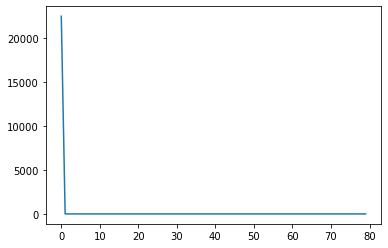

In [88]:
import matplotlib.pyplot as plt
plt.plot(sigmavector)

# We see that sigma is high only for the first feature
# It's nearly a 0 for all other features
# What does it tell us about the corpus that we are using?


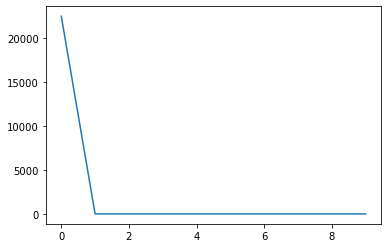

In [89]:
plt.plot(sigmavector[:10])

In [90]:
num_top_words = 10
vocab = list(new_space.keys())

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    print(top_words)
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

In [91]:
vmatrixT.shape

(80, 2000)

In [92]:
show_topics(vmatrixT.transpose()[:20])

<function show_topics.<locals>.<lambda> at 0x169af4dc0>


['ball beam heart mind prosper company flinch flare tooth optimism',
 'beam courage fire flinch discussion chatter kick heart cigarette bow',
 'boom burn girl flare kick fire concentration flame courage lessen',
 'boom body chatter burn face bow digress machine fear optimism',
 'body butler cigar digress head courage shudder roam throb gabble',
 'burn body bow butler digress head roam courage fire cigar',
 'body bow digress head prosper sale gabble courage roam hope',
 'chatter body bow butler face machine head sale hope roam',
 'child body bow butler digress concentration cigarette hope fire roam',
 'body bow butler determination thunder shot girl throb machine fire',
 'cigarette body bow butler cigar fire digress courage gabble rifle',
 'click bow body butler cigar digress fire determination shudder shot',
 'bow body butler cigar digress fire throb gabble determination rifle',
 'bow body company cigar butler digress fire shot fear kick',
 'body bow company cigar butler concentration 

In [93]:
# The topics above are basically dimensions which have features with the highest values for the first 20 words in our matrix
# We can use it to basically see what are the topics that the model captures, each line is supposed to be a separate theme/topic
# No clear topics here, but in a better space it should be possible to have a clearer picture

Now back to how we can use SVD space to construct vector representations.

In [94]:
def build_phrase_svd_space(phrase, svd_space):

    subject_space = svd_space[phrase[0]]
    verb_space = svd_space[phrase[1]]
        
    representation = np.zeros(len(svd_space))

    out = subject_space + verb_space
    #out = subject_space * verb_space
    #out = subject_space * 0.2 + verb_space * 0.8
    #out = subject_space * 0.0 + verb_space * 0.95 + (0.05 * subject_space * verb_space)

    return out

In [95]:
print(reference)
print(landmark_high)
print(landmark_low)

['face', 'glow']
['face', 'beam']
['face', 'burn']


In [96]:
ref = build_phrase_svd_space(reference, new_space)
lhigh = build_phrase_svd_space(landmark_high, new_space)
llow = build_phrase_svd_space(landmark_low, new_space)

#print(ref)
#print(lhigh)
#print(llow)

In [97]:
cosine(ref, lhigh)

1.0

In [98]:
cosine(ref, llow)

1.0

In [99]:
ref

array([-5.03386333e+03, -1.04714725e-12, -5.73110421e-14, -5.80505701e-14,
       -5.88094332e-14, -5.95884001e-14, -6.03882802e-14, -6.12099272e-14,
       -6.20542419e-14, -6.29221756e-14, -6.38147333e-14, -6.47329781e-14,
       -6.56780350e-14, -6.66510960e-14, -6.76534243e-14, -6.86863608e-14,
       -6.97513291e-14, -7.08498428e-14, -7.19835123e-14, -7.31540526e-14,
       -7.43632925e-14,  2.19278231e-12, -3.84529050e-14, -3.91217214e-14,
       -1.30180436e-14, -1.87204564e-14, -1.27909580e-13, -4.44015678e-13,
       -2.05828613e-13, -1.96101469e-13,  2.71800409e-13,  1.10954063e-13,
        2.11938597e-12,  6.43451852e-14,  1.32292534e-13, -1.12583192e-13,
       -2.28066005e-13, -5.99130851e-14,  3.65370131e-15, -3.39385192e-14,
        2.66705745e-14,  2.48470368e-14, -1.02257789e-14,  1.27937261e-14,
       -1.65317713e-14, -1.98378273e-14,  1.11462903e-14, -4.03585134e-15,
       -2.34868164e-14, -6.06489718e-16])

In [100]:
lhigh

array([-5.03386333e+03, -1.04714725e-12, -5.73110421e-14,  2.20592166e-12,
       -2.94047166e-14, -2.97942000e-14, -3.01941401e-14, -3.06049636e-14,
       -3.10271210e-14, -3.14610878e-14, -3.19073666e-14, -3.23664890e-14,
       -3.28390175e-14, -3.33255480e-14, -3.38267122e-14, -3.43431804e-14,
       -3.48756646e-14, -3.54249214e-14, -3.59917561e-14, -3.65770263e-14,
       -3.71816462e-14,  2.23058891e-12, -1.38808954e-25,  3.71677513e-27,
       -6.50499540e-28, -4.08315414e-27, -1.89542486e-28,  8.00110669e-28,
       -6.73800243e-29, -1.31790062e-27,  4.41019953e-28,  5.03699965e-28,
       -1.07089206e-27, -5.20012848e-28,  7.05115140e-28,  4.09499495e-28,
       -1.20067530e-28,  7.33450527e-28, -3.61552823e-28, -2.99678970e-29,
       -1.33665695e-28, -5.44670015e-28, -6.21774864e-29, -1.84392053e-29,
       -2.15147516e-28,  9.63312760e-29, -2.96730790e-29, -5.46505228e-28,
       -2.39684794e-29,  4.90536784e-28])

In [101]:
llow

array([-5.03386333e+03, -1.04714725e-12, -5.73110421e-14, -5.80505701e-14,
       -5.88094332e-14, -5.95884001e-14, -6.03882802e-14,  2.20355738e-12,
       -3.10271210e-14, -3.14610878e-14, -3.19073666e-14, -3.23664890e-14,
       -3.28390175e-14, -3.33255480e-14, -3.38267122e-14, -3.43431804e-14,
       -3.48756646e-14, -3.54249214e-14, -3.59917561e-14, -3.65770263e-14,
       -3.71816462e-14,  2.23058891e-12, -1.39824727e-25,  2.80601616e-27,
       -1.28701257e-28, -1.93806524e-27,  2.30011815e-28, -2.81014806e-28,
        1.11253448e-27, -1.28005577e-27,  7.24461606e-28,  5.56203316e-28,
       -8.16445108e-28, -2.98147940e-28, -5.67551722e-29,  1.57836841e-28,
       -1.32266157e-28,  7.26911506e-28, -1.83641792e-28,  7.64280925e-29,
       -2.77035419e-28, -2.56411332e-28, -3.49301394e-28, -2.22243205e-28,
       -4.89296937e-28,  6.85061761e-30, -5.27798679e-29, -3.61675792e-28,
       -1.15758737e-29,  6.34050662e-30])

---

## Preparing for homework

### Evaluating composition functions VS human judgements

As part of the homework, you will be asked to test how the cosine similarity between vectors of multiple vector spaces compares with the human judgements on the words collected in the previous step.

For comparison of several scores we can use [Spearman correlation coefficient](https://en.wikipedia.org/wiki/Spearman's_rank_correlation_coefficient) which is implemented in `scipy.stats.spearmanr` [here](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.spearmanr.html). The values of the Sperman correlation coefficient range from -1, 0 to 1, where 0 indicates no correlation, 1 perfect correaltion and -1 negative correlation. Hence, the greater the number the better. The p values tells us if the coefficient is statistically significant. For this to be the case, it must be less than or equal to $< 0.05$.

Some guidelines for implementing the correlation:

In [102]:
j = {}
j['landmark_high'] = []
j['landmark_low'] = []

for participant in dataset:
    #if participant == 'participant8':
    judgements = dataset[participant]
    for ref, landmark, score, gt in judgements:
        if ['face', 'glow'] == ref and landmark == ['face', 'beam']:
            j['landmark_high'].append(score)
        if ['face', 'glow'] == ref and landmark == ['face', 'burn']:
            j['landmark_low'].append(score)

#dataset['participant1'][-10:]

In [103]:
print(len(j['landmark_high']))
print(len(j['landmark_low']))

34
26


In [104]:
high = np.array([int(elem) for elem in j['landmark_high']])
high

array([7, 7, 6, 2, 6, 4, 5, 7, 3, 4, 6, 5, 5, 7, 6, 6, 7, 6, 6, 2, 5, 5,
       6, 7, 6, 4, 6, 6, 7, 4, 5, 6, 5, 5])

In [105]:
low = np.array([int(elem) for elem in j['landmark_low']])
low

array([5, 7, 3, 3, 4, 4, 5, 2, 3, 1, 1, 7, 2, 5, 4, 1, 4, 1, 6, 7, 4, 7,
       3, 4, 7, 3])

Important: try to correlate model's predictions with _averaged_ rankings from all humans (when available).

For example, for model A (simple additive), you would have two conditions: high and low rankings.
First, gather human judgements for your pairs.
Average them (it might happen that single pair does not have the same number of human judgements for either high or low condition.
For the same pairs, gather model A cosine scores.

In the end, you should have two vectors of same size.
Now, compute Spearman correlation on these two vectors and the result will be the correlation between model's predictions and human judgements for highly rated phrases.
Similar procedure should be done for pairs with low ratings.  

Question to consider: What would you do to get one single number for *all* human judgements vs. each model?

# References

1. Mitchell, J., & Lapata, M. (2008). Vector-based Models of Semantic Composition. In Proceedings of ACL-08: HLT (pp. 236–244). Association for Computational Linguistics.